In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import sklearn
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
#Initializing spotipy
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="97a410ffe0074311bf2ae56568f5be80",
                                                           client_secret="eb9a8cf6157b467380cb09f34c665949"))



In [3]:
#the playlists

#metal & rock playlist
metal_playlist = "7dUHWQzNHsfzQNuPkg0scx"
#classical playlist
classical_playlist = "37i9dQZF1DWWEJlAGA9gs0"
#pop playlist
pop_playlist = "6mtYuOxzl58vSGnEDtZ9uB"

In [4]:
#code to pass the 100 limit for the tracks got from the api

def get_all_tracks(playlist):
    results = sp.user_playlist_tracks("spotify", playlist)
    tracks = results['items'] # to pass in

    for oset in range(100,results['total'],100):
        results = sp.user_playlist_tracks("spotify", playlist, offset=oset)
        tracks += results['items']
    
    return tracks


all_tracks_metal = get_all_tracks(metal_playlist)
all_tracks_classical = get_all_tracks(classical_playlist)
all_tracks_pop = get_all_tracks(pop_playlist)

In [5]:
# Getting all the artists

def get_artists_from_playlist(playlist_id, tracks):
    
    tracks_from_playlist = tracks
    
    artists = []
    
    for track in tracks_from_playlist:
        artist_info = track['track']['artists'][0]
        artists.append(artist_info['name'])
    
    return artists

all_artist_metal = get_artists_from_playlist(metal_playlist,all_tracks_metal)
all_artist_classical = get_artists_from_playlist(classical_playlist,all_tracks_classical)
all_artist_pop = get_artists_from_playlist(pop_playlist,all_tracks_pop)

In [6]:
#get song names & track ids

def get_song_names(tracks):
    song_actual_names = [track['track']['name'] for track in tracks]
    track_ids = [track['track']['id'] for track in tracks]
    
    return song_actual_names,track_ids

song_names_metal,id_track_metal = get_song_names(all_tracks_metal)
song_names_classical,id_track_classical = get_song_names(all_tracks_classical)
song_names_pop,id_track_pop = get_song_names(all_tracks_pop)

In [8]:
#get all genres and popularity

def get_pop_and_genre(tracks):
    
    genre = []
    popularity = []
    
    for elem in tracks:
        artist01 = sp.artist(elem['track']["album"]["artists"][0]["external_urls"]["spotify"])
        genre.append(artist01["genres"][0] if artist01["genres"] else "genreless")
        popularity.append(artist01["popularity"])
        
        
    return genre,popularity

genre_metal,popularity_metal = get_pop_and_genre(all_tracks_metal)
genre_classical,popularity_classical = get_pop_and_genre(all_tracks_classical)
genre_pop,popularity_pop = get_pop_and_genre(all_tracks_pop)

In [9]:
#gathering main features and turning them into a dataframe

def main_features_to_df(track_ids):
    the_list = []
    for i in track_ids:
        the_list.append(sp.audio_features(i))
    #looping inside the nested list to be able to convert into a df    
    converted = [i for elem in the_list for i in elem]    
    df = pd.json_normalize(converted)
    
    return df
        
df_metal = main_features_to_df(id_track_metal)
df_classical = main_features_to_df(id_track_classical)
df_pop = main_features_to_df(id_track_pop)

In [10]:
# adding previous single gathered features to the current df

def add_features_to_df(song_actual_names,artist_list,genre,popularity,features_df):
    df_song_name = pd.DataFrame(song_actual_names, columns = ["song_name"])
    df_artists = pd.DataFrame(artist_list,columns = ["artists"])
    df_genre = pd.DataFrame(genre,columns = ["genre"])
    df_popularity = pd.DataFrame(popularity,columns = ["popularity"])
    
    final_boss_df = pd.concat([features_df, df_song_name,df_artists,df_genre,df_popularity], axis=1)
    
    return final_boss_df

final_df_metal = add_features_to_df(song_names_metal,all_artist_metal,genre_metal,popularity_metal,df_metal)
final_df_classical = add_features_to_df(song_names_classical,all_artist_classical,genre_classical,popularity_classical,df_classical)
final_df_pop = add_features_to_df(song_names_pop,all_artist_pop,genre_pop,popularity_pop,df_pop)

In [11]:
scaler = StandardScaler()

def scaling_df(current_df):
    df_to_scale = current_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    #scaler = StandardScaler()
    scaled_df02 = scaler.fit_transform(df_to_scale)
    scaled_df01 = pd.DataFrame(scaled_df02)
    
    #adding the non numerical wanted columns to the main scaled df                         
    scaled_df = scaled_df01.copy()
    scaled_df.columns = df_to_scale.columns
    scaled_df["song_name"] = current_df["song_name"]
    scaled_df["artists"] = current_df["artists"]
    scaled_df["genre"] = current_df["genre"]
    scaled_df
                             
    return scaled_df01,scaled_df

df_to_scale_metal,scaled_df_metal = scaling_df(final_df_metal)
df_to_scale_classical,scaled_df_classical = scaling_df(final_df_classical)
df_to_scale_pop,scaled_df_pop = scaling_df(final_df_pop)

In [12]:
scaled_df_metal

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,song_name,artists,genre
0,-1.619788,-0.321564,0.170621,0.316980,-1.178748,-0.480448,1.762177,1.430451,0.072919,-1.075455,-0.980338,-1.700556,The Dawning Of Orphiucus,Astra,genreless
1,0.140692,-1.992560,-0.992539,-3.008935,0.848358,-0.336624,2.188439,1.360263,-0.663644,0.082941,-1.051073,1.345337,Planet Caravan,Black Sabbath,album rock
2,-0.801262,-1.332140,-1.574120,-1.388756,0.848358,-0.103765,-0.615641,-1.063458,-0.252231,-1.071333,-0.570602,1.345337,The End,The Doors,acid rock
3,0.822797,-0.122108,1.624572,-1.450288,-1.178748,-0.418809,0.807217,-0.699480,0.351618,0.956891,-0.546590,1.345337,Riders on the Storm - New Stereo Mix,The Doors,acid rock
4,-1.100089,-0.751502,0.461412,-0.154929,-1.178748,-0.538663,1.250001,0.947235,-0.404852,-1.269621,0.520729,1.626496,Shine On You Crazy Diamond - Parts 1 - 7;Edit;...,Pink Floyd,album rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,0.718857,0.183724,-0.410959,0.171853,-1.178748,-0.274985,0.093475,1.238785,-0.365038,0.952769,-1.077206,1.157897,Lightning Song,Queens of the Stone Age,alternative metal
947,-1.171547,1.637535,1.042992,1.477753,0.848358,0.666723,-0.781520,1.206390,-0.026617,-0.226240,-0.052950,1.157897,The Blood Is Love,Queens of the Stone Age,alternative metal
948,-1.678254,1.783803,1.333782,1.588314,-1.178748,5.327321,-0.867664,-1.061433,-0.418123,-0.749785,2.119108,1.157897,Everybody Knows That You're Insane,Queens of the Stone Age,alternative metal
949,0.829293,-1.784239,1.333782,-0.670964,0.848358,-0.545512,2.271048,-0.971592,-0.165967,1.130032,-1.703389,-0.716498,Lough Erne Shore,Andy Irvine,british folk


## Lab - lab-unsupervised-learning-intro

In [13]:
#merging the different genres dataframes

scaled_complete_frames = [scaled_df_metal,scaled_df_classical,scaled_df_pop]
the_big_boi_frame = pd.concat(scaled_complete_frames)
the_big_boi_frame

#merging all the scaled numericals
scaled_numerical_frames = [df_to_scale_metal,df_to_scale_classical,df_to_scale_pop]
numericals_big_boi_frame = pd.concat(scaled_numerical_frames)

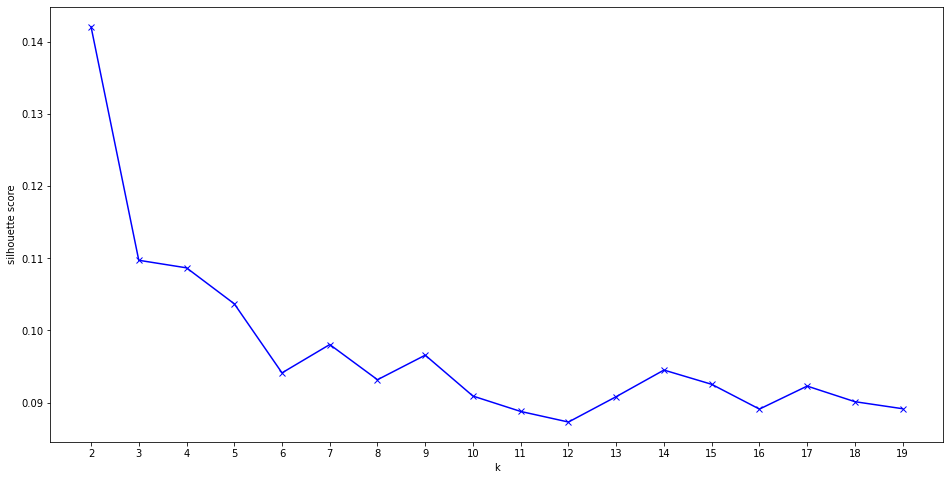

In [14]:
#applying silhouette to see how many clusters is a good number to apply

K = range(2, 20)

silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numericals_big_boi_frame)
    silhouette.append(silhouette_score(numericals_big_boi_frame, kmeans.predict(numericals_big_boi_frame)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

In [15]:
#applying the clustering

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(numericals_big_boi_frame)

KMeans(n_clusters=7, random_state=42)

In [16]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(numericals_big_boi_frame)
clusters


array([0, 6, 6, ..., 5, 1, 1], dtype=int32)

In [17]:
#assigning the clusters to the main final df
the_big_boi_frame["clusters"] = clusters

In [18]:
pd.Series(clusters).value_counts().sort_index()

0    195
1    104
2     41
3    240
4    274
5    263
6    293
dtype: int64

In [19]:
the_big_boi_frame.groupby(['clusters','genre'], as_index=False).count().sort_values(['clusters', 'key'], ascending=[True, False])[['genre', 'clusters', 'key']]

,genre,clusters,key
42,genreless,0,67
46,instrumental stoner rock,0,11
51,neo-psychedelic,0,10
45,instrumental rock,0,7
24,dark jazz,0,5
...,...,...,...
480,permanent wave,6,1
483,rap kreyol,6,1
484,rock-and-roll,6,1
485,russian modern classical,6,1


In [20]:
the_big_boi_frame = the_big_boi_frame.reset_index(drop=True)

In [21]:
#getting song and recomending song kinda here
def recomend_song():
    song_name = input("Choose a song: ")
    results = sp.search(q=f'track:{song_name}', limit=1)
    track_id = results['tracks']['items'][0]['id'] if results['tracks']['items'] else None
    while not track_id:
        return recomend_song()
    # get song features with the obtained id
    audio_features = sp.audio_features(track_id)
    #get song popularity and genre
    song_pop_genre = sp.artist(results['tracks']["items"][0]["album"]["artists"][0]["external_urls"]["spotify"])
    the_genre = song_pop_genre["genres"][0] if song_pop_genre["genres"] else "generless"
    the_pop = song_pop_genre["popularity"]
    #create the df
    df_uni_song = pd.DataFrame(audio_features)
    df_uni_song["popularity"] = the_pop
    #merge the datas
    new_features = df_uni_song[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','popularity']]
    df_uni_song["genre"] = the_genre
    #scale features
    #scaler = StandardScaler()
    scaled_x = scaler.transform(new_features)
    
    # predict cluster
    cluster = kmeans.predict(scaled_x)
    # filter dataset to predicted cluster
    filtered_df = the_big_boi_frame[the_big_boi_frame['clusters'] == cluster[0]][new_features.columns]
    # get closest song from filtered dataset
    closest, _ = pairwise_distances_argmin_min(scaled_x, filtered_df)
    # return it in a readable way
    print('\n [RECOMMENDED SONG]')
    return ' - '.join([the_big_boi_frame.loc[closest]['song_name'].values[0], the_big_boi_frame.loc[closest]['artists'].values[0]])

In [22]:
recomend_song()

Choose a song: The End	

 [RECOMMENDED SONG]


'Easier Said Than Done - Desert Sessions'